In [437]:
# notebook modeled off of visualize_predictions.ipynb authored by Prof. Marynel Vazquez 

# models
# gnn, no eec: 20210521_024706-m_gnn-e_False-l_0.0001-r_0.001-d_True-s_True, 4949
# gnn, eec: 20210521_104601-m_gnn-e_True-l_0.0001-r_0.001-d_True-s_True, 1200
# dante, no eec: 20210520_140954-m_dante-e_False-l_0.001-r_0.01-d_True-s_False, 1853
# dante, eec: 20210521_104822-m_dante-e_True-l_0.0001-r_0.001-d_True-s_True, 1695

# newer models
# gnn, no eec: 20210523_040942-m_gnn-e_False-el_False-l_0.0001-r_0.001, 4974, 1024 position dim, new ds loss, example frame: [2, 1, 20]
# gnn, eec: 20210523_040600-m_gnn-e_True-el_False-l_0.0001-r_0.001, 3214, 512 position dim, new ds loss, example frame: [2, 1, 20]
# dante, no eec: dante_eq_im_pos, 4035
# dante, eec: 20210523_040634-m_dante-e_True-el_False-l_0.0001-r_0.001, 2506, 512 position dim, new ds loss, example frame: [2, 1, 11000]

# models for paper
'''
baseline_cocktail: 2980
baseline_mnm: 3194
dante_pos: 4693
dante_pos_accel: 3218
dante_pos_img: 3688
dante_pos_img_accel: 3411
dante_pos_img_accel_label: 4073
gnn_pos: 3942
gnn_pos_accel: 4341
gnn_pos_img: 4905
gnn_pos_img_accel: 4900
gnn_pos_img_accel_label: 4941
'''

import os
import argparse
import json

# path to logs
logs_dir = '../eec-gnn/logs_paper/gnn_pos_accel'

# path to a trained model param.txt file
model_params = os.path.join(logs_dir,'params.txt')

# path to model checkpoint that we want to work with
model_checkpoint = os.path.join(logs_dir, 'best_model', 'group_f1t1_gnn_0.4341.pt')

# path to dataset
# dataset_path = '../datasets/dante/'

# set up the python path
import sys
sys.path.append("../")

# import required modules
import numpy as np
import torch

from torchvision.transforms import Compose
from transforms import y_to_A_list

from datasets.gnn import (
    CocktailPartyDataset as CocktailPartyDataset_GNN,
)
from datasets.gnn import (
    MatchnMingleDataset as MatchNMingleDataset_GNN,
)

from overwrites.geometric.point_pair_features import PointPairFeatures as PPF

from torch_geometric.transforms import Compose, Center, Distance, RadiusGraph

from datasets.dante.cocktail_party.dataset import (
    CocktailPartyDataset as CocktailPartyDataset_DANTE,
)
from datasets.dante.transforms.center_coordinate_frame import CenterCoordinateFrame
from datasets.dante.transforms.random_swap_dyad import RandomSwapDyad
from datasets.dante.transforms.rectangular_angle import RectangularAngle
from datasets.dante.collate_fn import collate_fn
from datasets.dante.subset import Subset

from models.gnn.gnn import GNN, GNN_DS
from models.gnn.agnn import AGNN
from models.dante.dante import DANTE, DANTE_DS

from overwrites.geometric.node_features import NodeFeatures
from torch_geometric.data import DataLoader as GeometricDataLoader

from torch.utils.data import DataLoader, WeightedRandomSampler

PRINT_INDICES = False
PRINT_DATASETS = True
PRINT_MODEL = True
max_people = None

# from clustering.ds import find_dominant_sets
from transforms import (
    y_to_A,
    true_affinity_to_dataset_groups,
    ds_groups_to_dataset_groups,
    unflatten_to_A_batch,
    unflatten_to_A,
    num_people_from_num_dyads,
)

from datasets.gnn.utils import sandwich_splitting
from datasets.gnn.utils import get_indices

use_cuda=False

In [438]:
# from dante_pytorch.inference

def load_model_params(params_file):
    """
    Helper function to load params from disk
    :param params_file: path to the parameters txt file
    :return: arguments used at training time for that model
    """
    # load params as suggested in https://stackoverflow.com/questions/42318915/saving-python-argparse-file
    parser = argparse.ArgumentParser()
    args = parser.parse_args("")
    with open(params_file, 'r') as f:
        args.__dict__ = json.load(f)
    return args

In [439]:
# from main.py, same except for no out_dir
def get_model(args, train_dataset, max_people, device):
    if args.model == "gnn" or args.model == "agnn":
        example = train_dataset[0]
        print("train_dataset[0]:", example)
        # print('example.x:', example.x)
        print("example.x:", example.x.shape)
        # print('example.edge_attr:', example.edge_attr)
        print("example.edge_attr:", example.edge_attr.shape)
        # for an N layer model, only the following count:
        #   - first N edge_hiddens
        #   - first N - 1 edge_targets
        #   - first N - 1 node_hiddens
        #   - first N - 1 node_targets

        max_iter = (
            args.max_iter if ((args.min_iter) == 0 or not args.eec) else args.min_iter
        )
        params = {
            "n_features": example.x.shape[1],
            "n_edge_features": example.edge_attr.shape[1],
            "n_edge_hidden_1": args.edge_hidden_1,
            "n_edge_hidden_2": args.edge_hidden_2,
            # "n_edge_hiddens": [[128, 32], [16, 16]],
            "n_edge_targets": [16, 1],
            # "n_node_hiddens": [[128, 32], [1]],
            "n_node_hidden_1": args.node_hidden_1,
            "n_node_hidden_2": args.node_hidden_2,
            "n_node_targets": [16, 1],
            "dropout": args.dropout,
            "thresh": args.thresh,
            "max_iter": max_iter,
            "min_eps": args.min_eps,
            "device": device,
            "expand_features": args.expand_features,
            "expand_dims": args.expand_dims,
            "img_mlp_features": args.img_mlp_features,
            "img_mlp_dims": args.img_mlp_dims,
            "early_stopping": args.early_stopping,
        }

        if args.eec:
            if args.model == "gnn":
                model = GNN_DS(
                    n_features=params["n_features"],
                    n_edge_features=params["n_edge_features"],
                    n_edge_hidden_1=params["n_edge_hidden_1"],
                    n_edge_hidden_2=params["n_edge_hidden_2"],
                    # n_edge_hiddens=params["n_edge_hiddens"],
                    n_edge_targets=params["n_edge_targets"],
                    n_node_hiddens_1=params["n_node_hidden_1"],
                    n_node_hiddens_2=params["n_node_hidden_2"],
                    # n_node_hiddens=params["n_node_hiddens"],
                    n_node_targets=params["n_node_targets"],
                    dropout=params["dropout"],
                    thresh=params["thresh"],
                    max_iter=params["max_iter"],
                    min_eps=params["min_eps"],
                    device=params["device"],
                    edge_projection_features=params["expand_features"],
                    edge_projection_dims=params["expand_dims"],
                    img_mlp_features=params["img_mlp_features"],
                    img_mlp_dims=params["img_mlp_dims"],
                    stop_gc=params["early_stopping"],
                ).to(device)
            else:
                raise NotImplementedError("Still working on AGNN EEC")
        else:
            model_class = GNN if args.model == "gnn" else AGNN
            model = model_class(
                n_features=params["n_features"],
                n_edge_features=params["n_edge_features"],
                n_edge_hiddens_1=params["n_edge_hidden_1"],
                n_edge_hiddens_2=params["n_edge_hidden_2"],
                # n_edge_hiddens=params["n_edge_hiddens"],
                n_edge_targets=params["n_edge_targets"],
                n_node_hiddens_1=params["n_node_hidden_1"],
                n_node_hiddens_2=params["n_node_hidden_2"],
                # n_node_hiddens=params["n_node_hiddens"],
                n_node_targets=params["n_node_targets"],
                dropout=params["dropout"],
                device=params["device"],
                edge_projection_features=params["expand_features"],
                edge_projection_dims=params["expand_dims"],
                img_mlp_features=params["img_mlp_features"],
                img_mlp_dims=params["img_mlp_dims"],
            ).to(device)

    else:
        example = train_dataset[0][0]
        num_features = example[0][0][0].shape[0]
        print("\n\n-------num_features:", num_features)
        # print('example[0][0][0]:', example[0][0][0])
        # print('example[0][0][0]:', example[0][0])

        max_iter = (
            args.max_iter if ((args.min_iter == 0) or not args.eec) else args.min_iter
        )
        params = {
            "input_feat": num_features,
            "dyad_mlp_dims": args.dyad_mlp,
            "context_mlp_dims": args.context_mlp,
            "dense_dims": args.dense_mlp,
            "dropout": args.dropout,
            "max_people": max_people,
            "device": device,
            "thresh": args.thresh,
            "max_iter": max_iter,
            "min_eps": args.min_eps,
            "expand_features": args.expand_features,
            "expand_dims": args.expand_dims,
            "img_mlp_features": args.img_mlp_features,
            "img_mlp_dims": args.img_mlp_dims,
            "early_stopping": args.early_stopping,
        }

        if args.eec:
            model = DANTE_DS(
                input_feat=params["input_feat"],
                dyad_mlp_dims=params["dyad_mlp_dims"],
                context_mlp_dims=params["context_mlp_dims"],
                dense_dims=params["dense_dims"],
                dropout=params["dropout"],
                max_people=params["max_people"],
                device=params["device"],
                thresh=params["thresh"],
                max_iter=params["max_iter"],
                min_eps=params["min_eps"],
                expand_features=params["expand_features"],
                expand_dims=params["expand_dims"],
                img_mlp_features=params["img_mlp_features"],
                img_mlp_dims=params["img_mlp_dims"],
                stop_gc=params["early_stopping"],
            ).to(device)
        else:
            model = DANTE(
                input_feat=params["input_feat"],
                dyad_mlp_dims=params["dyad_mlp_dims"],
                context_mlp_dims=params["context_mlp_dims"],
                dense_dims=params["dense_dims"],
                dropout=params["dropout"],
                max_people=params["max_people"],
                device=params["device"],
                expand_features=params["expand_features"],
                expand_dims=params["expand_dims"],
                img_mlp_features=params["img_mlp_features"],
                img_mlp_dims=params["img_mlp_dims"],
            ).to(device)

    if args.bootstrap:
        try:
            params_file = "/".join(args.bootstrap.split("/")[:-2]) + "/params.txt"
            with open(params_file) as f:
                loaded_params = json.load(f)
                print("loaded_params:\n", loaded_params)
        except Exception as e:
            print(
                f"Could not display loaded params - perhaps the param file is in an unexpected place - {e}"
            )
        print("params:", params)
        model.load_state_dict(
            torch.load(args.bootstrap, map_location=torch.device(device))
        )

    if PRINT_MODEL:
        print(model)
        print()
        print("Total Parameters:", sum(p.numel() for p in model.parameters()))
        print(
            "Trainable Parameters:",
            sum(p.numel() for p in model.parameters() if p.requires_grad),
        )
        print("________________________________")
        print()

    return model

In [440]:
# from main.py, same except returns number of positive and negative dyads

from datasets.gnn.utils import split_train_test_by_camera_day

def get_data_loaders_gnn(args, device):
    if args.dataset.startswith("cocktail_party"):
        if args.dataset == "cocktail_party":
            transforms = [Distance(norm=False)]
        elif args.dataset == "cocktail_party_head":
            transforms = [PPF(norm="head_norm")]
        elif args.dataset == "cocktail_party_body":
            transforms = [PPF(norm="body_norm")]
        else:
            transforms = [PPF(norm="head_norm"), PPF(norm="body_norm")]

        dataset = CocktailPartyDataset_GNN(
            root="./datasets/gnn/cocktail_party",
            transform=Compose([Center(), RadiusGraph(1e9)] + transforms),
            device=device,
        )

        train_indices, val_indices, test_indices = get_indices(
            len(dataset), args.num_folds, args.test_fold, args.percent_val
        )
    elif args.dataset.startswith("matchnmingle"):
        transforms = [Distance(norm=False)]
        print("dataset:", args.dataset)
        root_dir = "./datasets/gnn/matchnmingle"
        if args.dataset == "matchnmingle_accel_label":
            print("using matchnmingle_accel_label")
            root_dir = "./datasets/gnn/matchnmingle/accel_label"
        elif args.dataset == "matchnmingle_accel":
            print("using matchnmingle_accel")
            root_dir = "./datasets/gnn/matchnmingle/accel"
        elif args.dataset == "matchnmingle_camera_0":
            print("using matchnmingle_camera_0")
            root_dir = "./datasets/gnn/matchnmingle/camera_0"
        elif args.dataset == "matchnmingle_camera_1":
            print("using matchnmingle_camera_1")
            root_dir = "./datasets/gnn/matchnmingle/camera_1"
        elif args.dataset == "matchnmingle_camera_2":
            print("using matchnmingle_camera_2")
            root_dir = "./datasets/gnn/matchnmingle/camera_2"
        elif args.dataset == "matchnmingle_4_layers":
            print("using matchnmingle_4_layers")
            root_dir = "./datasets/gnn/matchnmingle/layers_4"
        elif args.dataset == "matchnmingle_4_layers_camera_0":
            print("using matchnmingle_4_layers_camera_0")
            root_dir = "./datasets/gnn/matchnmingle/layers_4_camera_0"
        elif args.dataset == "matchnmingle_4_layers_camera_1":
            print("using matchnmingle_4_layers_camera_1")
            root_dir = "./datasets/gnn/matchnmingle/layers_4_camera_1"
        elif args.dataset == "matchnmingle_4_layers_camera_2":
            print("using matchnmingle_4_layers_camera_2")
            root_dir = "./datasets/gnn/matchnmingle/layers_4_camera_2"

        dataset = MatchNMingleDataset_GNN(
            root=root_dir,
            transform=Compose([Center(), RadiusGraph(1e9)] + transforms),
            device=device,
        )

        if args.sandwich_splitting:
            train_indices, val_indices, test_indices = sandwich_splitting(
                [ex.frame_id for ex in dataset],
                prop=1.0 / 5,
            )
        else:
            train_indices, val_indices, test_indices = split_train_test_by_camera_day(
                [ex.frame_id for ex in dataset], dataset=args.dataset
            )
    else:
        raise NotImplementedError("Dataset Not Available")

    if PRINT_INDICES:
        print(f"Train - {len(train_indices)} - {train_indices}")
        print(f"Validation- {len(val_indices)} - {val_indices}")
        print(f"Test - {len(test_indices)} - {test_indices}")

    num_pos, num_neg = 0, 0
    for i in train_indices:
        y = dataset[i].y.flatten()
        A_list = y_to_A_list(y)
        num_neg += (A_list[A_list == 0]).shape[0]
        num_pos += (A_list[A_list == 1]).shape[0]

    train_weights = []
    for i in train_indices:
        y = dataset[i].y.flatten()
        A_list = y_to_A_list(y)
        n_neg = (A_list[A_list == 0]).shape[0]
        n_pos = (A_list[A_list == 1]).shape[0]
        train_weights.append(n_neg / num_neg + n_pos / num_pos)

    sampler = WeightedRandomSampler(
        train_weights, num_samples=len(train_indices), replacement=True
    )

    train_dataset = dataset[train_indices]
    val_dataset = dataset[val_indices]
    test_dataset = dataset[test_indices]

    if PRINT_DATASETS:
        print("Train:", train_dataset)
        print("Validation:", val_dataset)
        print("Test:", test_dataset)

    if not args.random_sampler:
        train_loader = GeometricDataLoader(
            train_dataset, batch_size=args.batch_size, sampler=sampler
        )
    else:
        train_loader = GeometricDataLoader(
            train_dataset, batch_size=args.batch_size, shuffle=True
        )

    # to allow greater parallelization
    train_metrics_loader = GeometricDataLoader(
        train_dataset, batch_size=len(train_indices), shuffle=False
    )

    val_loader = GeometricDataLoader(
        val_dataset, batch_size=len(val_indices), shuffle=False
    )
    test_loader = GeometricDataLoader(
        test_dataset, batch_size=len(test_indices), shuffle=False
    )

    # uncomment for visualization
    # for i in range(799,902):
    #     print('i:', i)
    #     plot(test_dataset[i])
    # plot_distribution(train_dataset)
    # plot_distribution(val_dataset)
    # plot_distribution(test_dataset)

    return train_dataset, test_dataset, test_loader, dataset

In [441]:
def get_data_loaders_dante(args, device, use_cuda):
    if args.dataset.startswith("cocktail_party"):
        name = "cocktail_party"
        if args.dataset == "cocktail_party":
            x, y, angles = 0, 1, []
        elif args.dataset == "cocktail_party_head":
            x, y, angles = 0, 1, [2]
        elif args.dataset == "cocktail_party_body":
            x, y, angles = 0, 1, [3]
        else:
            x, y, angles = 0, 1, [2, 3]
    elif args.dataset.startswith("matchnmingle"):
        x, y, angles = 0, 1, []
        name = "matchnmingle"
        if args.dataset == "matchnmingle_accel_label":
            name = "matchnmingle/accel_label"
        elif args.dataset == "matchnmingle_accel":
            name = "matchnmingle/accel"
        elif args.dataset == "matchnmingle_camera_0":
            name = "matchnmingle/camera_0"
        elif args.dataset == "matchnmingle_camera_1":
            name = "matchnmingle/camera_1"
        elif args.dataset == "matchnmingle_camera_2":
            name = "matchnmingle/camera_2"
        elif args.dataset == "matchnmingle_4_layers":
            name = "matchnmingle/layers_4"
        elif args.dataset == "matchnmingle_4_layers_camera_0":
            name = "matchnmingle/layers_4_camera_0"
        elif args.dataset == "matchnmingle_4_layers_camera_1":
            name = "matchnmingle/layers_4_camera_1"
        elif args.dataset == "matchnmingle_4_layers_camera_2":
            name = "matchnmingle/layers_4_camera_2"
    else:
        raise NotImplementedError("Dataset Not Available")

    # angles are the indices of the angle features in the dataset file
    # transform angles are the indices of the angle features in the pre_transform output
    print("angles:", angles)
    transform_angles = list(range(2, 2 + len(angles)))
    print("transform_angles:", transform_angles)
    transform = Compose(
        [
            # RandomSwapDyad(),  #  disabled due to DANTE symmetric
            CenterCoordinateFrame(
                x_index=x, y_index=y, angle_index=transform_angles, flip_y_prob=0.0
            ),
            RectangularAngle(angle_index=transform_angles),
        ]
    )

    # angle=[]->None, angle=[2]->head, angle=[3]->body, angle=[2,3]->head+body
    dataset = CocktailPartyDataset_DANTE(
        angles=angles,
        eec=args.eec,
        transform=transform,
        device=device,
        name=name,
    )

    print("name:", name)
    if name.startswith("matchnmingle"):
        print("using matchnmingle splitting")
        if args.sandwich_splitting:
            print("using sandwich splitting")
            train_indices, val_indices, test_indices = sandwich_splitting(
                dataset.stamps,
                prop=1.0 / 5,
            )
        else:
            print("using camera-day splitting")
            train_indices, val_indices, test_indices = split_train_test_by_camera_day(
                dataset.stamps, dataset=args.dataset
            )

    else:
        print("using cocktail party splitting")
        train_indices, val_indices, test_indices = get_indices(
            len(dataset), args.num_folds, args.test_fold, args.percent_val
        )

    if PRINT_INDICES:
        print(f"Train - {len(train_indices)} - {train_indices}")
        print(f"Validation- {len(val_indices)} - {val_indices}")
        print(f"Test - {len(test_indices)} - {test_indices}")

    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    test_dataset = Subset(dataset, test_indices)

    if PRINT_DATASETS:
        print("Train:", train_dataset)
        print("Validation:", val_dataset)
        print("Test:", test_dataset)

    data_loader_args = {
        "dataset": train_dataset,
        "batch_size": args.batch_size,
        "shuffle": args.random_sampler,
        "pin_memory": not use_cuda,
        "collate_fn": collate_fn,
    }

    if not args.random_sampler:
        train_weights = dataset.sample_weights(train_indices)
        sampler = WeightedRandomSampler(
            train_weights, num_samples=len(train_weights), replacement=True
        )
        data_loader_args["sampler"] = sampler

    train_loader = DataLoader(**data_loader_args)

    # remove sampler if present
    data_loader_args.pop("sampler", None)
    data_loader_args["batch_size"] = len(train_indices)
    train_metrics_loader = DataLoader(**data_loader_args)

    data_loader_args["batch_size"] = len(val_indices)
    data_loader_args["dataset"] = val_dataset
    val_loader = DataLoader(**data_loader_args)

    data_loader_args["batch_size"] = len(test_indices)
    data_loader_args["dataset"] = test_dataset
    test_loader = DataLoader(**data_loader_args)

    max_people = dataset.get_max_people()

    # TODO: DANTE Data Visualizations

    return train_dataset, dataset, test_loader, max_people, dataset.stamps, test_indices

In [442]:
# from dante_pytorch.inference
def load_model(params_file, checkpoint_file, device):
    """
    Helper function to load model given params
    :param params_file: params file
    :param checkpoint_file: checkpoint file
    :param device: torch device
    :return: tuple with model arguments and model in evaluation mode
    """
    # load model params and create model
    model_args = load_model_params(params_file)
    
    if model_args.model == "gnn" or model_args.model == "agnn":
        max_people = None
        train_dataset, _, _, _ = get_data_loaders_gnn(model_args, device)
    else:
        (
            train_dataset,
            _,
            _,
            max_people,
            _,
            _,
        ) = get_data_loaders_dante(model_args, device, use_cuda)
        
    print(model_args)
    
    model = get_model(model_args, train_dataset, max_people, device)
    model.eval()    # sets batch norm to evaluation mode

    # set model weights
    model.load_state_dict(torch.load(checkpoint_file, map_location=device), strict=False)

    return model_args, model

In [443]:
# set device
device = "cpu"

# load model params and create model
model_args, model = load_model(model_params, model_checkpoint, device)
print("Loaded the model:")

if model_args.model == "gnn" or model_args.model == "agnn":
    _, dataset, test_loader, full_dataset = get_data_loaders_gnn(model_args, device)
else:
    (
        train_dataset,
        dataset,
        test_loader,
        max_people,
        stamps,
        test_indices,
    ) = get_data_loaders_dante(model_args, device, use_cuda)
    
    
print("Loaded dataset with {} samples.".format(len(dataset)))

#print("Num positive dyads: {}".format(num_pos))
#print("Num negative dyads: {}".format(num_neg))

dataset: matchnmingle_accel
using matchnmingle_accel
unique frame starts: {'2-0', '0-2', '0-1', '2-1', '0-0', '1-1', '1-2', '2-2', '1-0'}
day_cam: 2-0 - len(day_cam_frames): 592 - num_prop_indices: 59
day_cam: 0-2 - len(day_cam_frames): 92 - num_prop_indices: 9
day_cam: 0-1 - len(day_cam_frames): 570 - num_prop_indices: 57
day_cam: 2-1 - len(day_cam_frames): 593 - num_prop_indices: 59
day_cam: 0-0 - len(day_cam_frames): 593 - num_prop_indices: 59
day_cam: 1-1 - len(day_cam_frames): 556 - num_prop_indices: 55
day_cam: 1-2 - len(day_cam_frames): 458 - num_prop_indices: 45
day_cam: 2-2 - len(day_cam_frames): 417 - num_prop_indices: 41
day_cam: 1-0 - len(day_cam_frames): 597 - num_prop_indices: 59
train_indices: 2696
val_indices: 886
test_indices: 886
Train: MatchnMingleDataset(2696)
Validation: MatchnMingleDataset(886)
Test: MatchnMingleDataset(886)
Namespace(batch_size=512, bootstrap=None, context_mlp=[32, 64], dataset='matchnmingle_accel', dense_mlp=[64, 32], dropout=0.0, dyad_mlp=[32, 

In [444]:
# from metrics/group_f1.py
from clustering.ds import dominant_sets_clustering

def get_groups(args, y_pred, y, pred_groups, ground_groups):

    for i in range(len(y)):
        # handles different possible transforms
        if args.model == "gnn":
            if args.eec:
                y_pred_new = y_pred[i]
            else:
                y_pred_new = dominant_sets_clustering(y_pred[i].double(), y_pred[i].shape[0], device, thresh=args.thresh, max_iter=args.max_iter, min_eps=args.min_eps, stop_gc=args.early_stopping)
            groups_pred = ds_groups_to_dataset_groups(y_pred_new, args.thresh)
            groups = true_affinity_to_dataset_groups(y_to_A(y[i]))
        else:
            if args.eec:
                groups = ds_groups_to_dataset_groups(y[i], args.thresh)
                groups_pred = ds_groups_to_dataset_groups(y_pred[i], args.thresh)
            else:
                mask = y[i] >= 0
                pred = y_pred[i][mask]
                truth = y[i][mask]

                num_people = num_people_from_num_dyads(pred.shape[0])
                A = unflatten_to_A(truth, num_people, torch.double, device)
                groups = true_affinity_to_dataset_groups(A)
                
                A = unflatten_to_A(pred, num_people, torch.double, device)
                
                groups_pred = ds_groups_to_dataset_groups(
                dominant_sets_clustering(A, num_people, device, thresh=args.thresh, max_iter=args.max_iter, min_eps=args.min_eps, stop_gc=args.early_stopping),
                    thres=args.thresh,
                )
                
        pred_groups.append(groups_pred)
        ground_groups.append(groups)

    return pred_groups, ground_groups

In [445]:
from datasets.dante.cocktail_party.read_dataset import read_dataset

# make predictions
def make_predictions(model, loader, dataset, args):
    """
    Helper function to make predictions on a frame-by-frame basis
    :param model: torch model
    :param dataset: dataset
    :return: dict with group predictions and ground-truth groups
    """
    
    # make predictions on a frame-by-frame basis
    pred_groups = []
    ground_groups = []
    num_people = []
    
    if args.model == "gnn" or args.model == "agnn":
        for data in loader:
        
            y_pred = model(data)

            y = []
            for i in range(data.ptr.shape[0] - 1):
                curr_ptr, next_ptr = data.ptr[i], data.ptr[i + 1]
                y_group = data.y[curr_ptr:next_ptr].flatten()
                num_people.append(len(y_group))
                y.append(y_group)
                
            pred_groups, ground_groups = get_groups(args, y_pred, y, pred_groups, ground_groups)
            
    else:
        for test_idx in test_indices:
            
            inputs, y = dataset[test_idx]
            data = (inputs[0].unsqueeze(0), inputs[1].unsqueeze(0), inputs[2].unsqueeze(0))
            y_pred = model([data])
            num_people.append(int(inputs[2].item()))
                           
            pred_groups, ground_groups = get_groups(args, y_pred, y.unsqueeze(0), pred_groups, ground_groups)
        
    return pred_groups, ground_groups, num_people

In [446]:
# pred_groups, ground_groups, num_people = make_predictions(model, test_loader, dataset, model_args)

#print("Pred Groups: ", pred_groups)
#print("\nGround Groups: ", ground_groups)
#print("\nNum People: ", num_people)

In [447]:
# from viz.py

import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import matplotlib.patches as mpatches

COLORS = list(mcolors.CSS4_COLORS.keys())
# can also use TABLEAU_COLORS or XKCD but not enough options
# the CSS4 colors aren't very good

def plot_ind(data, pred_group, ground_group, num_people, pos):
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    # fig.suptitle('Frame: ', i)
    
    if model_args.model == 'gnn':
        pos = data.pos[:, :2]
        
    colorsP = [0] * num_people
    colorsG = [0] * num_people
    
    for i in range(len(pred_group)):
        for j in range(len(pred_group[i])):
            colorsP[pred_group[i][j]] = COLORS[i*7]
            
    for i in range(len(ground_group)):
        for j in range(len(ground_group[i])):
            colorsG[ground_group[i][j]] = COLORS[i*7]

    ax1.scatter(pos[:, 0], pos[:, 1], color=colorsP, s=100)
    ax2.scatter(pos[:, 0], pos[:, 1], color=colorsG, s=100)
    
    ax1.set_title("Predicted")
    ax2.set_title("Ground")
    
    if model_args.model == 'gnn':
        ax1.set_xlim([-5, 5])
        ax1.set_ylim([-5, 5])

        ax2.set_xlim([-5, 5])
        ax2.set_ylim([-5, 5])
        
    else:
        ax1.set_xlim([0, 960])
        ax1.set_ylim([0, 540])

        ax2.set_xlim([0, 960])
        ax2.set_ylim([0, 540])        

    #fig.show()

In [448]:
def plot_full(dataset, pred_groups, ground_groups, num_people):
     
    plt.ion()
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    x,y = [],[]
    colorsP, colorsG = [], []
    sc1 = ax1.scatter(x, y, c=colorsP, s=100, cmap="rainbow")
    sc2 = ax2.scatter(x, y, c=colorsG, s=100, cmap="rainbow")
    
    ax1.set_title("Predicted")
    ax2.set_title("Ground")

    if model_args.model == 'gnn':
        plt.xlim(-5, 5)
        plt.ylim(-5, 5)
    else:
        plt.xlim(0, 960)
        plt.ylim(0, 540)
    
    plt.draw()

    for index in range(5):
        colors = np.random.random(num_people[index])
            
        if model_args.model == 'gnn':
            pos = dataset[index].pos[:, :2]
        else:
            pos = torch.Tensor(num_people[index], 2)
            _, all_features, _ = read_dataset([], name='matchnmingle')
            stamp = stamps[test_indices[index]]
            print("Stamp: ", stamp)
    
            for i in range(num_people[index]):
                pos[i, 0] = all_features[stamp][i][0]
                pos[i, 1] = all_features[stamp][i][1]
                   
        colorsP = [0] * num_people[index]
        colorsG = [0] * num_people[index]
        
        pred_group = pred_groups[index]
        for i in range(len(pred_group)):
            for j in range(len(pred_group[i])):
                colorsP[pred_group[i][j]] = COLORS[i]

        ground_group = ground_groups[index]
        for i in range(len(ground_group)):
            for j in range(len(ground_group[i])):
                colorsG[ground_group[i][j]] = COLORS[i]
                
        x = pos[:, 0]
        y = pos[:, 1]
        
        print(colorsP)
        print(num_people[index])
    
        sc1.set_offsets(np.c_[x, y])
        sc2.set_offsets(np.c_[x, y])
        sc1.set_color(colorsP)
        sc2.set_color(colorsG)
        
        fig.canvas.draw_idle()
        plt.pause(0.1)

In [449]:
'''
num_ex = 4 # plot 3rd example in the test dataset

print("Ground: ", ground_groups[num_ex])
print("Predicted: ", pred_groups[num_ex])

pos = torch.Tensor(num_people[num_ex], 2)

if model_args.model == 'gnn':
    plot_ind(dataset[num_ex], pred_groups[num_ex], ground_groups[num_ex], num_people[num_ex], pos)
else:
    _, all_features, all_num_people = read_dataset([], name='matchnmingle')
    stamp = stamps[test_indices[num_ex]]
    print("Stamp: ", stamp)

    for i in range(num_people[num_ex]):
        pos[i, 0] = all_features[stamp][i][0]
        pos[i, 1] = all_features[stamp][i][1]
    
    plot_ind(dataset[test_indices[num_ex]], pred_groups[num_ex], ground_groups[num_ex], num_people[num_ex], pos) 
    # dataset arg not used for dante
    
# plot_full(dataset, pred_groups, ground_groups, num_people)
'''

'\nnum_ex = 4 # plot 3rd example in the test dataset\n\nprint("Ground: ", ground_groups[num_ex])\nprint("Predicted: ", pred_groups[num_ex])\n\npos = torch.Tensor(num_people[num_ex], 2)\n\nif model_args.model == \'gnn\':\n    plot_ind(dataset[num_ex], pred_groups[num_ex], ground_groups[num_ex], num_people[num_ex], pos)\nelse:\n    _, all_features, all_num_people = read_dataset([], name=\'matchnmingle\')\n    stamp = stamps[test_indices[num_ex]]\n    print("Stamp: ", stamp)\n\n    for i in range(num_people[num_ex]):\n        pos[i, 0] = all_features[stamp][i][0]\n        pos[i, 1] = all_features[stamp][i][1]\n    \n    plot_ind(dataset[test_indices[num_ex]], pred_groups[num_ex], ground_groups[num_ex], num_people[num_ex], pos) \n    # dataset arg not used for dante\n    \n# plot_full(dataset, pred_groups, ground_groups, num_people)\n'

In [450]:
# from metrics/group_f1.py

def group_f1(groups_pred, groups, threshold):
    """
    Compute group F1 score
    :param groups_pred: list of predicted groups (each group should be a list with ids)
    :param groups: list of ground truth groups (each group should be a list with ids)
    :param threshold: threshold (% participants) for classifying groups as TP
    :return: F1 metric, (precision, recall), (TP, FP, FN)
    """
    n_pred, n = len(groups_pred), len(groups)

    # handle degenerate cases first
    if n_pred == 0 and n == 0:
        TP, FP, FN = 0, 0, 0
        precision, recall = 1.0, 1.0
    elif n_pred == 0 and n > 0:
        TP, FP, FN = 0, 0, n
        precision, recall = 1.0, 0.0
    elif n_pred > 0 and n == 0:
        TP, FP, FN = 0, n_pred, 0
        precision, recall = 0.0, 1.0
    else:
        TP = 0

        # for each ground truth group
        for _, true_group_ids in enumerate(groups):
            # for each predicted group
            for _, pred_group_ids in enumerate(groups_pred):
                intersect = list(set(true_group_ids).intersection(set(pred_group_ids)))
                max_length = max(len(true_group_ids), len(pred_group_ids))
                if len(intersect) / max_length >= threshold:
                    TP = TP + 1
                    break

        FP = n_pred - TP
        FN = n - TP

        precision = 1.0 * TP / (TP + FP)
        recall = 1.0 * TP / (TP + FN)

    f1 = 2 * (precision * recall) / (precision + recall + 1e-20)

    return f1, (precision, recall), (TP, FP, FN)

def compute(threshold):
    precision = []
    recall = []

    for index in range(len(num_people)):
        _, (pr, re),_ = group_f1(pred_groups[index], ground_groups[index], threshold)
        precision.append(pr)
        recall.append(re)

    avg_precision = sum(precision) / (len(precision) + 1e-15)
    avg_recall = sum(recall) / (len(recall) + 1e-15)
    f1 = 2.0 * avg_precision * avg_recall / (avg_precision + avg_recall + 1e-15)
    
    return f1, avg_precision, avg_recall

In [451]:
f1t1, prt1, ret1 = compute(1.0)
f1t2, prt2, ret2 = compute(2/3)

print("group_f1t1: ", f1t1)
print("precision_t1: ", prt1)
print("recall_t1", ret1)
print("group_f1t2/3: ", f1t2)

group_f1t1:  0.24433956462181097
precision_t1:  0.24216630184463117
recall_t1 0.24655218746640897
group_f1t2/3:  0.38943496264921


In [452]:
# by Austin Chen, from mm_visualization notebook

import csv
import cv2
import imageio

counts = [32, 30, 30]
with open("matchnmingle/manual_annotations/PARTICIPANTS.csv", 'r') as f:
    reader = csv.reader(f)
    participant_data = np.array([[int(x) for x in line] for line in reader])
    participant_sets = [participant_data[0: 32, 1], participant_data[32: 62, 1], participant_data[62: 92, 1]]
    
with open("matchnmingle/manual_annotations/CAMERA.csv", 'r') as f:
    reader = csv.reader(f)
    camera_data = np.array([[int(x) for x in line] for line in reader])
    camera_datasets = [camera_data[:, 0: 32], camera_data[:, 32: 62], camera_data[:, 62: 92]]
    
with open("matchnmingle/manual_annotations/LOST.csv", 'r') as f:
    reader = csv.reader(f)
    lost_data = np.array([line for line in reader])
    lost_datasets = [lost_data[:, 0: 32], lost_data[:, 32: 62], lost_data[:, 62: 92]]
    
with open("matchnmingle/manual_annotations/LABELS.csv", 'r') as f:
    reader = csv.reader(f)
    label_data = np.array([line for line in reader])
    label_datasets = [label_data[:, 0: 32 * 9], label_data[:, 32 * 9: 62 * 9], label_data[:, 62 * 9: 92 * 9]]
    
with open("matchnmingle/manual_annotations/DATA.csv", 'r') as f:
    reader = csv.reader(f)
    data = np.array([[int(x) for x in line] for line in reader])
    data_datasets = [data[:, 0: 32 * 7], data[:, 32 * 7: 62 * 7], data[:, 62 * 7: 92 * 7]]
    
with open("matchnmingle/manual_annotations/F-formationsGT/Day1.csv", 'r') as f:
    reader = csv.reader(f)
    ffday1_data = np.array([line for line in reader])
with open("matchnmingle/manual_annotations/F-formationsGT/Day2.csv", 'r') as f:
    reader = csv.reader(f)
    ffday2_data = np.array([line for line in reader])
with open("matchnmingle/manual_annotations/F-formationsGT/Day3.csv", 'r') as f:
    reader = csv.reader(f)
    ffday3_data = np.array([line for line in reader])
ff_datasets = [ffday1_data[1:, :], ffday2_data[1:, :], ffday3_data[1:, :]]

In [475]:
def VisualizeGround(day, camera, frame, dataset, models, stamps):
    '''
    video = cv2.VideoCapture(f"matchnmingle/videos/downsample/30min_day{day}_cam{camera}_20fps_960x540.MP4")
    video.set(cv2.CAP_PROP_POS_FRAMES, frame)
    
    ret, image = video.read()
    # if ret:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    '''
    name = str(frame)+'_'+str(day)+str(camera)+'.png'
    path = os.path.join('../eec-gnn/example_images',name)
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    participants = participant_sets[day - 1][camera_datasets[day - 1][frame, :] == camera]
    
    # Getting position features of participants in the frame
    positions = np.array([[data_datasets[day - 1][frame, 7 * i + j] for i in range(counts[day - 1])]
                          for j in range(1, 5)]).astype(int)[:, camera_datasets[day - 1][frame, :] == camera]
    
    # center_positions = np.array([[(positions[0, index] + positions[2, index]) / 2, (positions[1, index] + positions[3, index]) / 2] for index in range(6)], np.int32)
    
    for i in range(positions.shape[1]):
        x1, y1, x2, y2 = positions[:, i]
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 1)
        cv2.putText(image, str(participants[i]), (x1, y1 + 15), 1, 1, (255, 0, 255), 2)

    for formation in ff_datasets[day - 1]:
        if int(formation[3]) <= frame <= int(formation[4]):
            # All participants in the f-formation
            ff_all_participants = np.array([int(x) for x in formation[0].split(' ') if len(x) != 0])
            # Participants that are in the correct camera
            ff_participants = ff_all_participants[np.in1d(ff_all_participants, participants)]

            # Check that there are at least 2 participants present
            if len(ff_participants) > 1:
                indices = [int(np.argwhere(participant == participants)[0]) for participant in ff_participants]
                center_positions = np.array([[(positions[0, index] + positions[2, index]) / 2, (positions[1, index] + positions[3, index]) / 2] for index in indices], np.int32)
                if center_positions.size == 2:
                    cv2.circle(image, tuple(center_positions[0, :]), 3, (0, 255, 0), -1)
                else:
                    if len(center_positions) > 3:
                        for i in range(len(center_positions) - 1):
                            for j in range(i + 1, len(center_positions)):
                                cv2.line(image, tuple(center_positions[i]), tuple(center_positions[j]), (0, 255, 0), 6)
                    else:
                        cv2.polylines(image, [center_positions.reshape((-1,1,2))], True, (0, 255, 0), 6) 
    
    annotation_start = [12000, 0, 21600][day - 1]
    new_frame = int(1803 * (camera - 1) + 601 * (day - 1) + (frame - annotation_start) / 20)
    stamp = str(day-1) + '-' + str(camera-1) + '-' + str(new_frame)
    print(stamp)
    
    pred_groups, ground_groups = [], []
    if model_args.model == "gnn" or model_args.model == "agnn":
        
        plot_loader = GeometricDataLoader(dataset, batch_size=1, shuffle=False)
        i = 0
        for data in plot_loader:
            data_ex = data
            if stamp in full_dataset[i].frame_id:
                break
            else:
                i+=1
                
        y_pred = model(data_ex)

        y = []
        for i in range(data_ex.ptr.shape[0] - 1):
            curr_ptr, next_ptr = data_ex.ptr[i], data_ex.ptr[i + 1]
            y_group = data_ex.y[curr_ptr:next_ptr].flatten()
            y.append(y_group)
            num_people = len(y_group)

        pred_groups, ground_groups = get_groups(model_args, y_pred, y, pred_groups, ground_groups)

    else:
        # stamp = stamp + '-' + str(frame)
        # index = [idx for idx, s in enumerate(stamps) if stamp in s][0]
        index = stamps.index(stamp)
        
        dyad, context, n, y = dataset.examples[index]
        data = (dyad.unsqueeze(0), context.unsqueeze(0), n.unsqueeze(0))
        y_pred = model([data])
        num_people = int(n.item())

        pred_groups, ground_groups = get_groups(model_args, y_pred, y.unsqueeze(0), pred_groups, ground_groups)

    pred_group = pred_groups[0]
    ground_group = ground_groups[0]
    
    print("Predicted: ", pred_group)
    print("Ground: ", ground_group)

    pos = torch.Tensor(num_people, 2)
    if model_args.model == 'gnn':
        pos = data_ex.pos[:, :2]
        for i in range(num_people):
            pos[i, 0] = (pos[i, 0]+4.95)*100
            pos[i, 1] = (pos[i, 1]+3)*100
    else:
        for i in range(num_people):
            pos[i, 0] = dataset.all_features[stamp][i][0]
            pos[i, 1] = dataset.all_features[stamp][i][1]

    plt.imshow(image)

    plt.scatter(pos[:, 0], pos[:, 1], s=100)
    
    plt.xticks([])
    plt.yticks([])
    
    plt.show()
    
    #cv2.imwrite(f"{frame}_{day}{camera}.png", cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

In [498]:
def VisualizePred(day, camera, frame, dataset, model, stamps):
    '''
    video = cv2.VideoCapture(f"matchnmingle/videos/downsample/30min_day{day}_cam{camera}_20fps_960x540.MP4")
    video.set(cv2.CAP_PROP_POS_FRAMES, frame)
    
    ret, image = video.read()
    # if ret:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    '''
    name = str(frame)+'_'+str(day)+str(camera)+'.png'
    path = os.path.join('../eec-gnn/example_images',name)
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    participants = participant_sets[day - 1][camera_datasets[day - 1][frame, :] == camera]
    # Getting position features of participants in the frame
    positions = np.array([[data_datasets[day - 1][frame, 7 * i + j] for i in range(counts[day - 1])]
                          for j in range(1, 5)]).astype(int)[:, camera_datasets[day - 1][frame, :] == camera]

    for i in range(positions.shape[1]):
        x1, y1, x2, y2 = positions[:, i]
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 1)
        cv2.putText(image, str(participants[i]), (x1, y1 + 15), 1, 1, (255, 0, 255), 2)

    annotation_start = [12000, 0, 21600][day - 1]
    new_frame = int(1803 * (camera - 1) + 601 * (day - 1) + (frame - annotation_start) / 20)
    stamp = str(day-1) + '-' + str(camera-1) + '-' + str(new_frame)
    print(stamp)
    
    pred_groups, ground_groups = [], []
    
    if model_args.model == "gnn" or model_args.model == "agnn":
        
        plot_loader = GeometricDataLoader(dataset, batch_size=1, shuffle=False)
        i = 0
        for data in plot_loader:
            data_ex = data
            if stamp in full_dataset[i].frame_id:
                break
            else:
                i+=1
                
        y_pred = model(data_ex)

        y = []
        for i in range(data.ptr.shape[0] - 1):
            curr_ptr, next_ptr = data.ptr[i], data.ptr[i + 1]
            y_group = data.y[curr_ptr:next_ptr].flatten()
            y.append(y_group)
            num_people = len(y_group)

        pred_groups, ground_groups = get_groups(model_args, y_pred, y, pred_groups, ground_groups)

    else:
        # stamp = stamp + '-' + str(frame)
        index = stamps.index(stamp)
        
        dyad, context, n, y = dataset.examples[index]
        data = (dyad.unsqueeze(0), context.unsqueeze(0), n.unsqueeze(0))
        y_pred = model([data])
        num_people = int(n.item())

        pred_groups, ground_groups = get_groups(model_args, y_pred, y.unsqueeze(0), pred_groups, ground_groups)
        
    pred_group = pred_groups[0]
    ground_group = ground_groups[0]
    
    print("Predicted: ", pred_group)
    print("Ground: ", ground_group)
            
    pos = torch.Tensor(num_people, 2)
    if model_args.model == 'gnn':
        pos = data_ex.pos[:, :2]
        for i in range(num_people):
            pos[i, 0] = (pos[i, 0]+4)*100
            pos[i, 1] = (pos[i, 1]+1.85)*100
    else:
        for i in range(num_people):
            pos[i, 0] = dataset.all_features[stamp][i][0]
            pos[i, 1] = dataset.all_features[stamp][i][1]

    for group in pred_group:
        for i in range(len(group) - 1):
            for j in range(i + 1, len(group)):
                cv2.line(image, tuple([int(x) for x in pos[group[i]].tolist()]), tuple([int(x) for x in pos[group[j]].tolist()]), (255, 0, 0), 6)
    
    plt.scatter(pos[:, 0], pos[:, 1], s=100)
    
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(image)
    
    plt.show()
    
    #cv2.imwrite(f"{frame}_{day}{camera}.png", cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

2-2-5242
Predicted:  [[1, 3], [0], [2], [4], [5], [6]]
Ground:  [[0], [1, 3], [2], [4], [5], [6]]


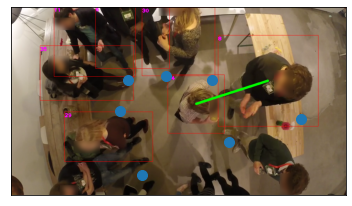

2-2-5242
Predicted:  [[1, 3], [0], [2], [4], [5], [6]]
Ground:  [[0], [1, 3], [2], [4], [5], [6]]


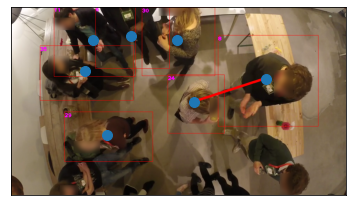

group_f1t1:  0.24433956462181097
group_f1t2/3:  0.38943496264921


In [499]:
if model_args.model == 'gnn':
    # day, camera, frame
    # day 1 frames: 12-24k
    # day 2 frames: 0-12k
    # day 3 frames: 21600-33600
    stamps = []
    VisualizeGround(3, 3, 30280, full_dataset, model, stamps)
    VisualizePred(3, 3, 30280, full_dataset, model, stamps)
else:
    VisualizeGround(1, 1, 12640, dataset, model, stamps)
    VisualizePred(1, 1, 12640, dataset, model, stamps)
    
f1t1, prt1, ret1 = compute(1.0)
f1t2, prt2, ret2 = compute(2/3)

print("group_f1t1: ", f1t1)
print("group_f1t2/3: ", f1t2)